<a href="https://colab.research.google.com/github/LeyloJohnny/Computational-Neuroscience/blob/main/HMM_Introduction_ANDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fitting a Hidden Markov Model
#### Excerpted/condensed/expanded from SSM/notebooks
####  Authors: David Wyrick, Luca Mazzucato, Scott Linderman

We're going to show how to fit a HMM using the State-Space-Modelling code written by [Scott Linderman](https://github.com/lindermanlab/ssm). To start, we will generate synthetic data from a ground-truth instantiation of the HMM class, and fit another HMM to that generated data. A HMM with gaussian observitions is the simplest graphical model available in _SSM_, and is the building block for more complicated HMMs like Auto-Regressive HMMs. We will start with this model and then move on to fitting a HMM with poisson observations. 


Requirements: autograd==1.3, scipy==1.5.2, seaborn==0.11, git+git://github.com/lindermanlab/ssm

In [1]:
# Run and restart the kernel before proceeding
!pip install autograd==1.3
!pip install scipy==1.5.2
!pip install seaborn==0.11
!pip install git+git://github.com/lindermanlab/ssm

     |████████████████████████████████| 25.9MB 153kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
     |████████████████████████████████| 286kB 27.8MB/s 
  Found existing installation: seaborn 0.11.1
    Uninstalling seaborn-0.11.1:
      Successfully uninstalled seaborn-0.11.1
  Cloning git://github.com/lindermanlab/ssm to /tmp/pip-req-build-yv4v37ys
  Running command git clone -q git://github.com/lindermanlab/ssm /tmp/pip-req-build-yv4v37ys
  Created wheel for ssm: filename=ssm-0.0.1-cp37-cp37m-linux_x86_64.whl size=399510 sha256=9aec29f29db3a795d25a982ee6551d9c7bacc7db43b7ed209bde90b8478fff24
  Stored in directory: /tmp/pip-ephem-wheel-cache-pabizy4b/wheels/82/71/55/886c7f4ed86fbde1aa2f4e598d010b6d9a761be84320ac95ec
Successfully built ssm


In [2]:
import autograd.numpy as np
import autograd.numpy.random as npr
npr.seed(3)

import ssm
from ssm.util import find_permutation
from ssm.plots import gradient_cmap, white_to_color_cmap

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange"
    ]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)


## Overview

An HMM consists of a set of hidden state variable, $z$, which can take on one of $K$ values (for our purposes, HMMs will always have discrete states), along with a set of transition probabilities for how the hidden state evolves over time. 
In other words, we have $z_t \in \{1, \ldots, K\}$, where $z_t = k$ denotes that the hidden variable is in state $k$ at time $t$.


The key assumption in an HMM is that only the most recent state affects the next state. In mathematical terms:

$$
p(z_t \mid z_{t-1}, z_{t-2}, \ldots, z_1) = p(z_t \mid z_{t-1})
$$

In an HMM, we don't observe the state itself. Instead, we get a noisy observation of the state at each time step according to some observation model. We'll use $x_t$ to denote the observation at time step $t$. The observation can be a vector or scalar. We'll use $D$ to refer to the dimensionality of the observation. A few of the supported observation models are:

1. **Gaussian**: Each discrete state $z_t = k$ is associated with a $D$-dimensional mean $\mu_k$ and covariance matrix $\Sigma_k$. Each observation $z_t$ comes from a Gaussian distribution centered at the associated mean, with the corresponding covariance.

2. **Poisson**: Each discrete state $z_t = k$ is associated with a $D$-dimensional rate $\lambda_k$ that determines the probability of observing x events (spikes) with each time window for any given unit (neuron).

Note: _SSM_ supports many other observation models for HMMs. Check them out in the source code (observations.py)! 

In [3]:
##===== Let's create a ground-truth HMM from which to generate data from =====##
# Set the parameters of the HMM
time_bins = 200   # number of time bins
num_states = 5    # number of discrete states
obs_dim = 2       # dimensionality of observation

# Make an HMM
true_hmm = ssm.HMM(num_states, obs_dim, observations="gaussian")

# Manually tweak the means to make them farther apart
thetas = np.linspace(0, 2 * np.pi, num_states, endpoint=False)
true_hmm.observations.mus = 3 * np.column_stack((np.cos(thetas), np.sin(thetas)))

In [4]:
##===== Use HMM as a generative model =====##
time_bins = 1000
true_states, synthetic_data = true_hmm.sample(time_bins)

#As a baseline, let's calculate the log proability of the synthetic data given the current model parameters
true_ll = true_hmm.log_probability(synthetic_data)

In [5]:
##===== Plot the observation distributions =====##
lim = .85 * abs(synthetic_data).max()

#create mesh grid
XX, YY = np.meshgrid(np.linspace(-lim, lim, 100), np.linspace(-lim, lim, 100))
data = np.column_stack((XX.ravel(), YY.ravel()))

#Get log-likelihood of mesh grid so we can plot the probability density
lls = true_hmm.observations.log_likelihoods(data, np.zeros((data.shape[0], 0)), np.ones_like(data, dtype=bool), None)

Below, we plot the samples obtained from the HMM, color-coded according to the underlying state. The solid curves show regions of of equal probability density around each mean. The thin gray lines trace the latent variable as it transitions from one state to another.

Text(0.5, 1.0, 'Observation Distributions')

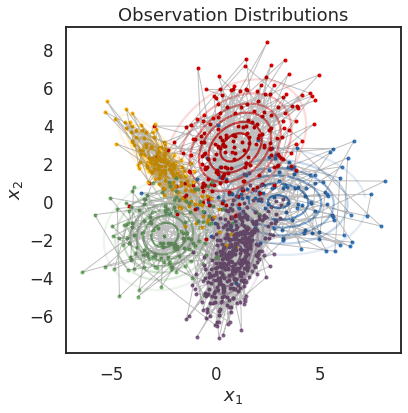

In [6]:
plt.figure(figsize=(6, 6))
for k in range(num_states):
    plt.contour(XX, YY, np.exp(lls[:,k]).reshape(XX.shape), cmap=white_to_color_cmap(colors[k]))
    plt.plot(synthetic_data[true_states==k, 0], synthetic_data[true_states==k, 1], 'o', mfc=colors[k], mec='none', ms=4)
    
plt.plot(synthetic_data[:,0], synthetic_data[:,1], '-k', lw=1, alpha=.25)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Observation Distributions")


Below, we visualize each component of of the observation variable as a time series. The colors correspond to the latent state. The dotted lines represent the "true" values of the observation variable (the mean) while the solid lines are the actual observations sampled from the HMM.

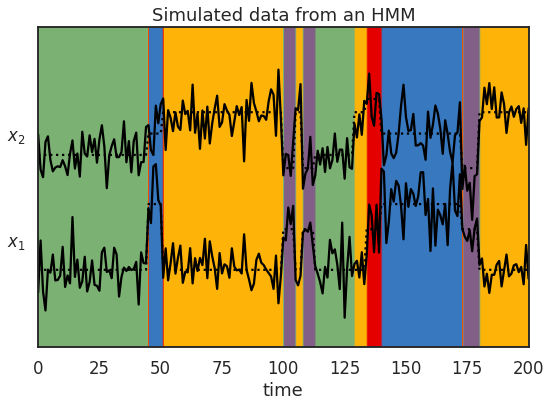

In [7]:
##===== Plot the data and latent states over time =====##
lim = 1.05 * abs(synthetic_data).max()
time_bins = 200
plt.figure(figsize=(8, 6))
plt.imshow(true_states[None,:time_bins],
           aspect="auto",
           cmap=cmap,
           vmin=0,
           vmax=len(colors)-1,
           extent=(0, time_bins, -lim, (obs_dim)*lim))

#Get the average value for each state
Ey = true_hmm.observations.mus[true_states]

#On the same figure, plot the generated data with the latent state which generated it
for d in range(obs_dim):
    plt.plot(synthetic_data[:,d] + lim * d, '-k')
    plt.plot(Ey[:,d] + lim * d, ':k')

#Plotting parameters
plt.xlim(0, time_bins)
plt.xlabel("time")
plt.yticks(lim * np.arange(obs_dim), ["$x_{}$".format(d+1) for d in range(obs_dim)])
plt.title("Simulated data from an HMM")
plt.tight_layout()


# Fit an HMM to synthetic data
This is all fine, but so far we haven't done anything that useful. It's far more interesting to learn an HMM from data. In the following cells, we'll use the synthetic data we generated above to fit an HMM from scratch. This is done in the following lines:

`
hmm = ssm.HMM(num_states, obs_dim, observations="gaussian")
hmm_lls = hmm.fit(obs, method="em", num_em_iters=N_iters)
`

In the first line, we create a new HMM instance called `hmm` with a gaussian observation model, as in the previous case. Because we haven't specified anything, the transition probabilities and observation means will be randomly initialized. In the next line, we use the `fit` method to learn the transition probabilities and observation means from data. We set the method to `em` (expectation maximization) and specify the maximum number of iterations which will be used to fit the data. The `fit` method returns a numpy array which shows the log-likelihood of the data over time. We then plot this and see that the EM algorithm quickly converges.

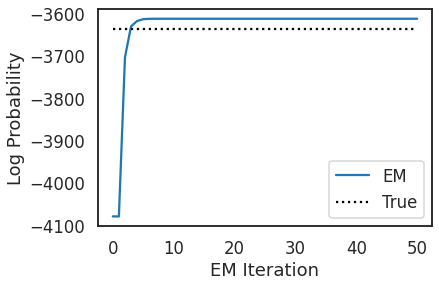

In [8]:
N_iters = 50
num_states = 5    # number of discrete states
obs_dim = 2       # dimensionality of observation

##===== Create HMM object to fit =====## 
hmm = ssm.HMM(num_states, obs_dim, observations="gaussian")

#This beautiful line of code hides all the business of fitting Hidden Markov models to data under the hood.
#Go look at the source code and marvel at how code should be written. 
hmm_lls = hmm.fit(synthetic_data, method="em", num_iters=N_iters, init_method="kmeans")

#Plot log-likelihood over iterations compared to the baseline log-likelihood we calculated earlier
plt.plot(hmm_lls, label="EM")
plt.plot([0, N_iters], true_ll * np.ones(2), ':k', label="True")
plt.xlabel("EM Iteration")
plt.ylabel("Log Probability")
plt.legend(loc="lower right")
plt.show()

The below cell is a bit subtle. In the first section, we sampled from the HMM and stored the resulting latent state $z$ in a variable called `state`. 
Now, we are treating our observations from the previous section as data, and seeing whether we can infer the true state given only the observations. However, there is no guarantee that the states we learn correspond to the original states from the true HMM. In order to account for this, we need to find a permutation of the states of our new HMM so that they align with the states of the true HMM from the prior section. This is done in the following two lines:

`most_likely_states = hmm.most_likely_states(obs)
hmm.permute(find_permutation(true_states, most_likely_states))
`  
  
In the first line, we use the `most_likely_states` method to infer the most likely latent states given the observations.  In the second line we call the `find_permutation` function the permutation that best matches the true state. We then use the `permute` method on our `hmm` instance to permute its states accordingly.



In [9]:
# Find a permutation of the states that best matches the true and inferred states
#Use viterbi method to detmerine most likely state 
most_likely_states = hmm.most_likely_states(synthetic_data)
hmm.permute(find_permutation(true_states, most_likely_states))

Below, we plot the inferred states ($z_{\mathrm{inferred}}$) and the true states ($z_{\mathrm{true}}$) over time. We see that the two match very closely, but not exactly. The model sometimes has difficulty inferring the state if we only observe that state for a very short time.

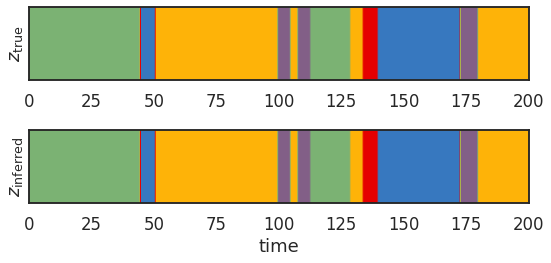

In [10]:
##===== Exercise =====##
# Plot the true and inferred discrete states; How do they compare?
hmm_z = hmm.most_likely_states(synthetic_data)

plt.figure(figsize=(8, 4))
plt.subplot(211)
plt.imshow(true_states[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(0, time_bins)
plt.ylabel("$z_{\\mathrm{true}}$")
plt.yticks([])

plt.subplot(212)
plt.imshow(hmm_z[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(0, time_bins)
plt.ylabel("$z_{\\mathrm{inferred}}$")
plt.yticks([])
plt.xlabel("time")

plt.tight_layout()

### Exercise: visualize the Transition Matrices
The dynamics of the hidden state in an HMM are specified by the transition probabilities $p(z_t \mid z_{t-1})$. It's standard to pack these probabilities into a stochastic matrix $A$ where $A_{ij} = p(z_t = j \mid z_{t-1} = i)$.

In SSM, we can access the transition matrices using `hmm.transitions.transition` matrix. In the following two lines, we retrives the transition matrices for the true HMM, as well as the HMM we learned from the data, and compare them visually.

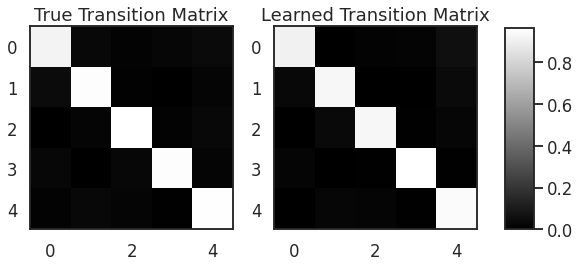

In [11]:
##===== Exercise =====##
# Plot the true and inferred discrete states; How do they compare?
true_transition_mat = true_hmm.transitions.transition_matrix
learned_transition_mat = hmm.transitions.transition_matrix

fig = plt.figure(figsize=(8, 4))
plt.subplot(121)
im = plt.imshow(true_transition_mat, cmap='gray')
plt.title("True Transition Matrix")

plt.subplot(122)
im = plt.imshow(learned_transition_mat, cmap='gray')
plt.title("Learned Transition Matrix")

cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.show()

# Model Selection

This is great and all, but what do you do if you don't know how many latent states are needed to describe the data? Model selection is an iterative process of fitting models with different model parameters on training data and calculating the log-likelihood on heldout data. The goal is to find a peak in the log-likelihood at which point increasing the model parameter of interest (in our case, the # of latent states) actually makes the model fit worse. In practice, log-likelihood plots rarely peak, but plateau very slowly as the model adds more and more parameters. Various methods, including Bayesian Information Criterion, incorporate the # of model parameters into the measure of model selection, effectively putting a penalty on adding more model paramters. 

$$
BIC = k ln(n) - 2 LL
$$

where k is the # of parameters of the model and n is the # of data points.

What we will find is that our model selection does indeed reveal that 5 states is the best to fit our model to the data,which is what we expect! This is shown as the elbow in the curve of the log-likehood (the "elbow method" before the plateau) plots and in the minimum in the BIC measure. 

In [12]:
from sklearn.model_selection import KFold

##===== K-fold Cross-Validation =====##
#There's no avoiding it! 

#Generate more data for cross-validation
time_bins = 10000
true_states, synthetic_data = true_hmm.sample(time_bins)

#Create kfold cross-validation object which will split data for us
nKfold = 5
kf = KFold(n_splits=nKfold, shuffle=True, random_state=None)

#Just for sanity's sake, let's check how it splits the data
#So 5-fold cross-validation uses 80% of the data to train the model, and holds 20% for testing
for ii, (train_index, test_index) in enumerate(kf.split(synthetic_data)):
    print(f"kfold {ii} TRAIN:", len(train_index), "TEST:", len(test_index))
    
#10 different nnumber of latent states
#5-fold cross-validation
#That's 50 model fits! Thankfully this can be parallelized fairly easily
max_states = 10
ll_training = np.zeros((max_states,nKfold))
ll_heldout = np.zeros((max_states,nKfold))
BIC_heldout = np.zeros((max_states,nKfold))

hmm_z_ms = np.zeros((max_states,time_bins))
#Outer loop over the parameter for which you're doing model selection for
for iS, num_states in enumerate(range(1,max_states+1)):
    #Number of parameters for the model: (transition matrix) + (mean values for each state) + (covariance matrix for each state)
    K = num_states*num_states + num_states*obs_dim + num_states*obs_dim
    
    #Inner loop over kfolds
    for iK, (train_index, test_index) in enumerate(kf.split(synthetic_data)):
        nTrain = len(train_index); nTest = len(test_index)#*obs_dim
        
        #Split data
        training_data = synthetic_data[train_index]
        test_data = synthetic_data[test_index]
        
        #Create HMM object to fit
        hmm = ssm.HMM(num_states, obs_dim, observations="gaussian")

        #fit on training data
        hmm_lls = hmm.fit(training_data, method="em", num_iters=N_iters)#, init_method="kmeans")
        
        #Compute log-likelihood for each dataset
        ll_training[iS,iK] = hmm.log_probability(training_data)/nTrain
        ll_heldout[iS,iK] = hmm.log_probability(test_data)/nTest
        
        #Let's calculate the BIC as well for this
        BIC_heldout[iS,iK] = K*np.log(nTest) - 2*hmm.log_probability(test_data)
        
    #Let's do a full model fit and get the state-sequence
    hmm = ssm.HMM(num_states, obs_dim, observations="gaussian")
    hmm_lls = hmm.fit(synthetic_data, method="em", num_iters=N_iters)
    most_likely_states = hmm.most_likely_states(synthetic_data)
    
    hmm_z_ms[iS,:] = hmm.most_likely_states(synthetic_data)

    
        

kfold 0 TRAIN: 8000 TEST: 2000
kfold 1 TRAIN: 8000 TEST: 2000
kfold 2 TRAIN: 8000 TEST: 2000
kfold 3 TRAIN: 8000 TEST: 2000
kfold 4 TRAIN: 8000 TEST: 2000


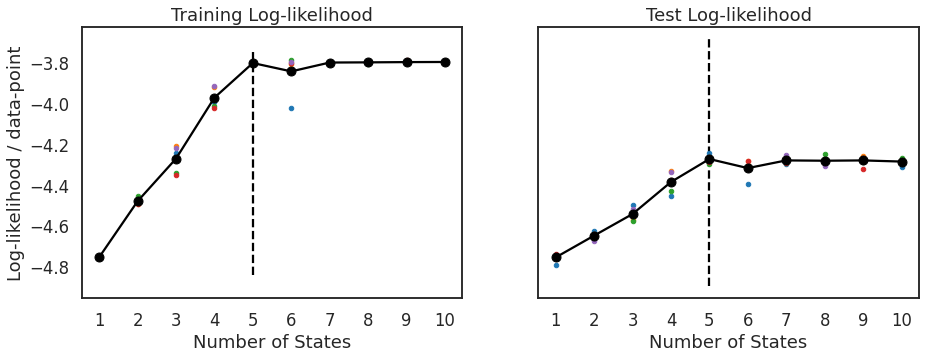

In [16]:
##===== Exercise =====##
#Plot the log-likelihood of the training and test datasets

fig, axes = plt.subplots(1,2,figsize=(15,5),sharey=True)

#Training data
axes[0].plot(np.arange(1,11),ll_training,'.')
axes[0].plot(np.arange(1,11),np.mean(ll_training,axis=1),'-ok')
axes[0].set_title('Training Log-likelihood')
axes[0].set_ylabel('Log-likelihood / data-point')

axes[1].plot(np.arange(1,11),ll_heldout,'.')
axes[1].plot(np.arange(1,11),np.mean(ll_heldout,axis=1),'-ok')
axes[1].set_title('Test Log-likelihood')

for ax in axes:
    ax.set_xticks(np.arange(1,11))
    ax.set_xlabel('Number of States')
    ax.vlines(5,*ax.get_ylim(),ls='--',color='k')

In [ ]:
#as well as the Bayesian Information Criterion

In [ ]:
## Generate more data with true_hmm
time_bins = 10000
true_states, synthetic_data = true_hmm.sample(time_bins)

#As a baseline, let's calculate the log proability of the synthetic data given the current model parameters
true_ll = true_hmm.log_probability(synthetic_data)

In [ ]:
#Let's fit a HMM one more time, but instead of using the verberti method to obtain the most-likely latent state sequence,
#we will get the Maximum a posteriori estimation of the latent state sequence. this way, we can impose a probability threshold 
#and look at only time points where the model is sure it found the right state; this is usually what you want to do because you don't really know if the model is doing a good job capturing the complexity of the data
num_states = 5

#Let's do a full model fit and get the state-sequence
hmm = ssm.HMM(num_states, obs_dim, observations="gaussian")
hmm_lls = hmm.fit(synthetic_data, method="em", num_iters=N_iters)

#For visualization purposes
most_likely_states = hmm.most_likely_states(synthetic_data)
hmm.permute(find_permutation(true_states, most_likely_states))
most_likely_states = hmm.most_likely_states(synthetic_data)

#Look at this one line magic! One line
posterior_probabilities, expected_joints, log_likes = hmm.expected_states(synthetic_data)

##===== Exercise =====##
#Plot the posterior probabilities together and obtain the MAP estimate of the lateatent state sequence



# Post-Fitting Exercises 
I always tell people that the hard part about fitting a state-space model to data is not the inference part, but the post-fit analysis and interpretation. The hard part of inference is done for us by Scott Linderman and company in this handy SSM package. What you get out of a successful HMM fit is a state sequence and the associated posterior probabilities. Since it's your data, it's your job to make sense of the segmentation done for you by the HMM. Some questions you can ask: do state transitions occur at specific points in a trial? Or during a particular behavior? Do some states last longer than others? what aspect of the data does each state capture. In the case of of a simple gaussian HMM, this is easy to answer. the mean and variance of each state. For an ARHMM though, what do the AR matrices capture? Similarly for the more complicated state space models.

For our simple gaussian HMM, let's look at how well the model did at classifying each datapoint to its corresponding latent state. I chose a random seed at the beginning of the notebook so these distributions would be well separate. If you generated a new "ground truth" model from which to produce synthetic data from, you might get overlapping distributions that may not be as easy to separate with another HMM. Try it out! 


> - State Duration distributions
> - State Usage, overall and per trial
> - Model Parameters characterizing each state
> - State transition points relative to other variables important to an experiment (task variables, behavior, etc)

In [ ]:
synthetic_data_sub = synthetic_data[:1000]
most_likely_states_sub = most_likely_states[:1000]
true_states_sub = true_states[:1000]
##===== Plot the observation distributions =====##
lim = .85 * abs(synthetic_data_sub).max()

#create mesh grid
XX, YY = np.meshgrid(np.linspace(-lim, lim, 100), np.linspace(-lim, lim, 100))
data = np.column_stack((XX.ravel(), YY.ravel()))

#Get log-likelihood of mesh grid so we can plot the probability density
lls = hmm.observations.log_likelihoods(data, np.zeros((data.shape[0], 0)), np.ones_like(data, dtype=bool), None)

fig, axes = plt.subplots(1,2,figsize=(12, 6))

ax = axes[0]
for k in range(num_states):
    ax.contour(XX, YY, np.exp(lls[:,k]).reshape(XX.shape), cmap=white_to_color_cmap(colors[k]))
    ax.plot(synthetic_data_sub[most_likely_states_sub==k, 0], synthetic_data_sub[most_likely_states_sub==k, 1], 'o', mfc=colors[k], mec='none', ms=4)
    ax.plot(hmm.observations.mus[k].T,'*',color=colors[k])
    
ax.plot(synthetic_data_sub[:,0], synthetic_data_sub[:,1], '-k', lw=1, alpha=.25)
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_title("Inferred Observation Distributions")

#Get log-likelihood of mesh grid so we can plot the probability density
lls = true_hmm.observations.log_likelihoods(data, np.zeros((data.shape[0], 0)), np.ones_like(data, dtype=bool), None)

ax = axes[1]
for k in range(num_states):
    ax.contour(XX, YY, np.exp(lls[:,k]).reshape(XX.shape), cmap=white_to_color_cmap(colors[k]))
    ax.plot(synthetic_data_sub[true_states_sub==k, 0], synthetic_data_sub[true_states_sub==k, 1], 'o', mfc=colors[k], mec='none', ms=4)
    ax.plot(true_hmm.observations.mus[k].T,'*',color=colors[k])
    
ax.plot(synthetic_data_sub[:,0], synthetic_data_sub[:,1], '-k', lw=1, alpha=.25)
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_title("True Observation Distributions")

# Poisson HMM
Let's do a similar exercise - generating data from a 'ground-truth model' and then fitting a separate HMM to the data, but using a poisson observation model instead of gaussian. 

In [ ]:
##===== Let's create a ground-truth HMM from which to generate data from =====##
# Set the parameters of the HMM
time_bins = 1000   # number of time bins
num_states = 5     # number of discrete states
nNeurons = 100     # number of neurons
obs_dim = nNeurons # dimensionality of observation

# Make an HMM
true_hmm = ssm.HMM(num_states, obs_dim, observations="poisson")

#Let's specify the firing rate vectors ourselves
true_firing_rates = np.zeros((num_states,nNeurons))

#Let's also specify the max firing rate (spikes/time-step, not Hz)
max_firing_rates = [20, 30, 5, 25, 15]
for k, mFR in enumerate(max_firing_rates):
    true_firing_rates[k,:] = np.random.rand(1,nNeurons)*mFR

In [ ]:
##===== Use HMM as a generative model =====##
time_bins = 1000
true_states, synthetic_spikes = true_hmm.sample(time_bins)

#As a baseline, let's calculate the log proability of the synthetic data given the current model parameters
true_ll = true_hmm.log_probability(synthetic_spikes)

Again let's look at the observations synthetic data and the corresponding latent state sequence which generated it. It should be fairly obvious by eye when a state change occurs. Maybe a bit more obvious than real data :)

In [ ]:
fig, axes = plt.subplots(2,1,figsize=(8, 10),gridspec_kw={'height_ratios':[10,1]})

tPlot = 250
axes[0].imshow(synthetic_spikes[:tPlot].T,
           aspect="auto",
           cmap='gray_r',
           extent=(0, tPlot, 0, nNeurons))

axes[0].set_ylabel('Neuron ID')

axes[1].imshow(true_states[None,:tPlot], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)

# Exercise: Fit poisson HMM to synthetic data and compare the inferred state sequence to that of the true state sequence